In [4]:
!pip install torch torchvision
!pip install opencv-python
!pip install numpy
!pip install filterpy
!pip install scipy
!pip install -U --pre "yt-dlp[default]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=1e7e763708a8ee03f6ce25381bdb34693c25d64ba963437ed68d239b5c7eb278
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 83.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websocket

# 1. Introduction
Multi-Object Tracking (MOT) is a crucial capability in computer vision, especially in dynamic environments like sports analytics. In this assignment, we will leverage Faster R-CNN, a state-of-the-art object detection model, to detect and track soccer players and the ball throughout a soccer match video. This forms the foundation for more advanced tracking techniques using Kalman Filters, which will be explored in subsequent tasks.

## Objectives:

Implement object detection using Faster R-CNN.
Detect "person" and "ball" classes in a soccer game video.
Visualize detection results with bounding boxes.
Prepare for temporal reasoning using Kalman Filters.

In [5]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
%matplotlib inline

## Device Setup

We will use GPU if available to speed up computations. If a GPU is not available, the code will fall back to using the CPU.


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Faster R-CNN Model Overview
Faster R-CNN is an advanced object detection model that consists of two main components:
1. **Region Proposal Network (RPN)**: Generates candidate bounding boxes or "region proposals" that may contain objects.
2. **Fast R-CNN**: Uses these proposals to classify objects and refine the bounding boxes.

In our implementation, we use a pre-trained Faster R-CNN model from `torchvision`, which is trained on the COCO dataset.

## ResNet Architecture
As we stack more layers, you'd expect the network to ge., right? Well, not always. Sometimes, adding more layers actually makes the network perform worse. This is known as the degradation problem.

ResNet, short for Residual Network, was introduced to tackle this exact . The cool idea behind ResNet is the use of **Residual Blocks**. Think of these blocks as shortcuts that let information flow directly through the network, skipping some layers. This helps in two major ways:

- **Easier Training**: By allowing gradients to flow directly through these shortcuts, ResNet makes it easier to train very deep networks without the gradients vanishing or exploding.
- **Better Performance**: These shortcuts let the network learn residual functions, meaning the network can focus on learning the difference between the input and the desired output, which often makes learning more efficient.

### Key Components of ResNet:
- **Residual Blocks**:  
  Each residual block has a couple of conlly two or three). There's a skip connection that bypasses these layers and adds the original input to the output of the convolutional layers. This addition helps the network learn residual mappings instead of trying to learn the entire transformation from scratch.

- **Skip Connections**:  
  Also called identity shortcuts, these connections pass the input directly to the output. They help in mitigating the vanishing gradient problem by providing a direct path for the gradient during backpropagation. Essentially, they make sure that even if some layers learn something not useful, the original input can still flow through the network.

- **Bottleneck Architecture**:  
  To keep things efficient, especially in deeper networks, ResNet uses a bottleneck design in its residual blocks. This involves a sequence of 1x1, 3x3, and 1x1 convolutions. The 1x1 convolutions reduce and then restore the number of channels, which cuts down on computation while mamore computational power.

### Why ResNet?
- **Ease of Training**: The skip connections make it simpler to train deeper networks by alleviating issues like vanishing gradients.
- **Performance**: ResNet architectures have set new benchmarks in various computer vision tasks, proving their effectiveness.
- **Flexibility**: ResNet is a robust backbone that can be used in many detection models, including Faster R-CNN, providing high-quality feature maps for object detection tasks.

## Integration with Faster R-CNN
Now, let's see how ResNet fits into the Faster R-CNN framework.

In Faster R-CNN, ResNet acts as the **backbone network**. Its job is to extract rich feature representations from the input images. These features are then used by the Region Proposal Network (RPN) and the Fast R-CNN components to perform object detection.

### How ResNet Enhances Faster R-CNN:
- **Feature Extraction**:  
  ResNet efficiently pulls out hierarchical features from images, capturing everything from edges and textures to complex shapes and object parts.

- **Depth and Complexity**:  
  Using a deeper ResNet model (like ResNet-50) allows the network to understand more intricate patterns, which improves its ability to detect objects of various sizes and in different contexts.

- **Transfer Learning**:  
  We use a ResNet backbone that's pre-trained on a large dataset like ImageNet. This means Faster R-CNN can leverage these learned features, speeding up training and boosting performance, especially for tasks like detecting soccer players and the ball.

- **Efficiency**:  
  The residual connections in ResNet ensure that feature extraction is both deep and computationally efficient, which is super important for apam  and complex environments like a soccer match.

## Loading the Pre-trained Model
We load the pre-trained Faster R-CNN model and move it to the configured device (GPU or CPU). The model is set to evaluation mode to disable training-specific operations like dropoice('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
set.


In [7]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model = model.to('cuda')
model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 172MB/s]  


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Image Preprocessing
Before passing an image to the model, we need to transform it into a format suitable for the neural network. We use `torchvision.transforms` to convert the image into a tensor


In [8]:
transform = T.Compose([
    T.ToTensor()
])

In [9]:
!yt-dlp -f "bestvideo+bestaudio" -k https://www.youtube.com/watch?v=l3NJNFmg09k

[youtube] Extracting URL: https://www.youtube.com/watch?v=l3NJNFmg09k
[youtube] l3NJNFmg09k: Downloading webpage
[youtube] l3NJNFmg09k: Downloading ios player API JSON
[youtube] l3NJNFmg09k: Downloading mweb player API JSON
[youtube] l3NJNFmg09k: Downloading player 0ccfa671
[youtube] l3NJNFmg09k: Downloading m3u8 information
[info] l3NJNFmg09k: Downloading 1 format(s): 136+251
[download] Destination: Football match [l3NJNFmg09k].f136.mp4
[download] 100% of   11.07MiB in 00:00:00 at 25.71MiB/s;33m00:000m
[download] Destination: Football match [l3NJNFmg09k].f251.webm
[download] 100% of  497.43KiB in 00:00:00 at 12.18MiB/s;33m00:000m
[Merger] Merging formats into "Football match [l3NJNFmg09k].mkv"


In [10]:
video_path = 'Football match [l3NJNFmg09k].mkv'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
else:
    print("Video opened successfully")

Video opened successfully


### Explanation: This function takes a video frame as input, converts it to the appropriate format, performs object detection, and filters the results to retain only "person" and "sports ball" detections with confidence scores above the specified threshold.

In [11]:
def get_predictions(frame, threshold=0.5):

    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = transform(image).to(device)
    
    with torch.no_grad():
        predictions = model([img])
    
    pred_boxes = predictions[0]['boxes'].detach().cpu().numpy()
    pred_scores = predictions[0]['scores'].detach().cpu().numpy()
    pred_labels = predictions[0]['labels'].detach().cpu().numpy()
    
    score_mask = pred_scores >= threshold
    pred_boxes = pred_boxes[score_mask]
    pred_scores = pred_scores[score_mask]
    pred_labels = pred_labels[score_mask]

    label_mask = np.isin(pred_labels, [1, 37])  # 'person' and 'sports ball'
    pred_boxes = pred_boxes[label_mask]
    pred_scores = pred_scores[label_mask]
    pred_labels = pred_labels[label_mask]
    return pred_boxes, pred_labels, pred_scores

In [12]:
# COCO Class Names
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball'
]

def draw_boxes(frame, boxes, labels):
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box.astype(int)
        label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
        # Set color based on label
        if label == 'person':
            color = (255, 0, 0)  # Blue in BGR
        elif label == 'sports ball':
            color = (0, 0, 255)  # Red in BGR
   
        cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color=color, thickness=2)
        # Put the label text above the bounding box
        cv2.putText(frame, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, color, 2)
    return frame

# Explanation: This loop processes each frame of the video:

Reading Frames: Frames are read sequentially using OpenCV's VideoCapture.
Detection: For each frame, detections are made using the get_predictions function.
Visualization: Detected objects are visualized by drawing bounding boxes and labels.
Writing Frames: The processed frame is written to an output video file.
Progress Tracking: Every 50 frames, the script prints the progress and elapsed time.

In [13]:
# Define the codec and create VideoWriter object
output_video_path = 'task1_football.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Get the total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames in the video: {total_frames}")

# Process and save the video
frame_count = 0
start_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Get predictions
    boxes, labels, scores = get_predictions(frame)
    frame = draw_boxes(frame, boxes, labels)
    out.write(frame)
    frame_count += 1

    if frame_count % 50 == 0:
        elapsed_time = time.time() - start_time
        print(f'Processed {frame_count}/{total_frames} frames in {elapsed_time:.2f} seconds')




# Release everything

cap.release()
out.release()


print(f"Processed video saved to {output_video_path}")


Total frames in the video: 1075
Processed 50/1075 frames in 8.11 seconds
Processed 100/1075 frames in 15.17 seconds
Processed 150/1075 frames in 22.24 seconds
Processed 200/1075 frames in 29.42 seconds
Processed 250/1075 frames in 36.42 seconds
Processed 300/1075 frames in 43.47 seconds
Processed 350/1075 frames in 50.52 seconds
Processed 400/1075 frames in 57.62 seconds
Processed 450/1075 frames in 64.81 seconds
Processed 500/1075 frames in 72.05 seconds
Processed 550/1075 frames in 79.21 seconds
Processed 600/1075 frames in 86.43 seconds
Processed 650/1075 frames in 93.73 seconds
Processed 700/1075 frames in 100.99 seconds
Processed 750/1075 frames in 108.32 seconds
Processed 800/1075 frames in 115.93 seconds
Processed 850/1075 frames in 123.56 seconds
Processed 900/1075 frames in 131.12 seconds
Processed 950/1075 frames in 138.73 seconds
Processed 1000/1075 frames in 146.34 seconds
Processed 1050/1075 frames in 153.78 seconds
Processed video saved to task1_football.mp4


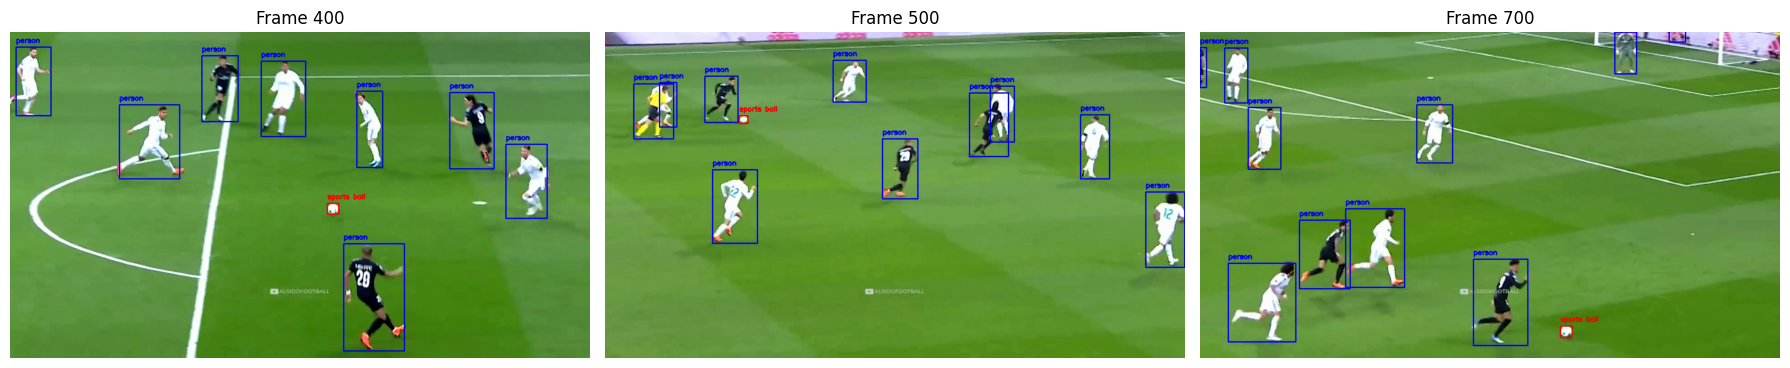

In [14]:
import cv2
import matplotlib.pyplot as plt

# Re-initialize the video capture for reading frames
cap = cv2.VideoCapture(output_video_path)

# Define a list of frame numbers to read (you can modify this list as needed)
frame_numbers = [400, 500, 700]


n_frames = len(frame_numbers)
fig, axes = plt.subplots(1, n_frames, figsize=(n_frames * 6, 6))  # Adjust the width (6) as necessary

# Loop through each specified frame number
for idx, frame_number in enumerate(frame_numbers):
    # Set the video capture to the specific frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    
    if ret:
        # Get the height and width of the frame (h, w)
        h, w = frame.shape[:2]
        
        # Convert the frame to RGB for displaying
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Plot the frame in the corresponding subplot
        axes[idx].imshow(frame_rgb)
        axes[idx].axis('off')
        axes[idx].set_title(f'Frame {frame_number}')
    else:
        print(f"Failed to read frame {frame_number}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Release the video capture object
cap.release()


## Visualizing Object Detections

In the following images, we can see how the Faster R-CNN model, with ResNet as the backbone, performs on frames extracted from the soccer match video. The model successfully detects and draws bounding boxes around soccer players and the ball, which are the two primary classes we are interested in: **"person"** and **"sports ball"**.

### Explanation of the Visualizations:

1. **Frame 400:**
   - The model detects multiple players on the field, each enclosed within a blue bounding box labeled "person."
   - The ball is also accurately detected and labeled as "sports ball" with a red bounding box.
   - Notice how the model effectively differentiates between the players and the ball, even when objects are close to one another.

2. **Frame 500:**
   - Here, we see a similar pattern of detections with players running or standing in various positions.
   - The ball is again successfully detected, even when it is in motion.
   - The model demonstrates robustness in detecting players and the ball from different angles and in varying positions on the field.

3. **Frame 700:**
   - In this frame, players are more spread out, and the ball is closer to the action.
   - The bounding boxes are well placed, and the labels are clear, demonstrating the model's ability to handle different scenes effectively.
   - Even as players move quickly across the field, the model maintains accurate detections.

### Observations:
- **Consistency:** The model consistently identifies players and the ball across frames, which is essential for tracking objects in a video.
- **Bounding Box Precision:** The bounding boxes are generally well aligned with the players and the ball, indicating that the model is reliable for object detection in sports analytics.
- **Potential Improvements:** While the model performs well, there may be instances where it struggles with occlusions (e.g., when players overlap) or with faster-moving objects like the ball. These could be areas to improve with further training or by integrating temporal reasoning techniques like Kalman Filters.

These visualizations showcase the effectiveness of Faster R-CNN with ResNet for multi-object detection in a dynamic sports setting, providing a solid foundation for advanced tracking techniques in future tasks.


# DeepSort Implementation

In [15]:
!cd /kaggle/working/

# Object Detection and Tracking with YOLOv5 and DeepSORT

This Python script, `detect.py`, is designed to perform object detection using the YOLOv5 model and to track detected objects in real-time using DeepSORT. Let’s break down the functionality, especially focusing on DeepSORT, how it works, why it’s used, and its integration in the code.

## Overview of the Script
The main goal of this script is to run object detection on various input sources (images, videos, streams, etc.) and then use DeepSORT for tracking detected objects across frames. Here’s how the script is structured:

- **Imports and Setup**: Essential libraries and modules, such as YOLOv5, utility functions, and DeepSORT, are imported.
- **Run Function**: This function initializes the model, performs inference, and integrates DeepSORT for object tracking.

---

## YOLOv5 and DeepSORT Integration
### What is YOLOv5?
YOLOv5 (You Only Look Once version 5) is a state-of-the-art object detection model that is efficient and accurate. It processes images in real-time and detects objects, outputting bounding boxes and class labels. YOLOv5 is used for object detection in this script.

### What is DeepSORT?
DeepSORT (Deep Simple Online and Realtime Tracking) is an object tracking algorithm. It extends the original SORT algorithm (Simple Online and Realtime Tracking) by using a deep learning-based appearance descriptor. DeepSORT enables robust tracking by associating detected objects across frames based on both spatial and visual features.

---# How DeepSORT Works

DeepSORT (Deep Simple Online and Realtime Tracking) enhances the original SORT (Simple Online and Realtime Tracking) algorithm by incorporating appearance information. This enhancement significantly improves tracking accuracy, especially in complex scenarios where multiple objects move closely together or occlude each other. Let’s dive deeper into the mechanisms involved:

## 1. Appearance Feature Extraction
- DeepSORT uses a pre-trained neural network to extract **appearance features** from each detected object. These features are high-dimensional vectors that describe the visual characteristics of an object, such as its color, shape, and texture.
- The **appearance features** are crucial because they help distinguish objects that may have similar spatial characteristics but look different. This allows the algorithm to match the same object across different frames, even if the object temporarily disappears or gets occluded.
- **How It Works**: The feature extractor processes an image of the detected object and outputs a feature vector. This vector is then used in the matching process to ensure that objects are tracked accurately based on their appearance.

## 2. Matching Strategy
- DeepSORT combines **motion information** (where an object is expected to move) with **appearance features** (what the object looks like) to match detections across frames.
- The matching process involves computing a **distance metric** between the current detections and the existing tracks. The most commonly used metric in DeepSORT is **cosine similarity**, which measures how similar two feature vectors are. The goal is to minimize this distance, ensuring that the same object is matched across frames.
- **Nearest Neighbor Distance Metric**: The algorithm uses a nearest neighbor search to find the best match for each detected object. This is done by comparing the feature vectors of the current detections with those of the existing tracks. The lower the distance, the more likely the objects are the same.

## 3. Kalman Filtering
- The **Kalman filter** is a mathematical model used to predict the future position of an object based on its past motion. It is particularly useful in maintaining consistent tracking, even when objects are temporarily occluded or move rapidly.
- **How It Works**: The Kalman filter uses a set of equations to estimate the object's next position. It continuously updates these estimates as new measurements (detections) are received. This ensures that the object’s position is predic- **Equations of the Kalman Filter**:
  - **Prediction Step**:
    $$
    \hat{x}_{k|k-1} = F \hat{x}_{k-1|k-1} + B u_k
    $$
    $$
    P_{k|k-1} = F P_{k-1|k-1} F^T + Q
    $$
    - $\hat{x}_{k|k-1}$: Predicted state vector.
    - $F$: State transition matrix.
    - $P_{k|k-1}$: Predicted covariance matrix.
    - $Q$: Process noise covariance - **Update Step**:
  $$
  K_k = P_{k|k-1} H^T (H P_{k|k-1} H^T + R)^{-1}
  $$
  $$
  \hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (z_k - H \hat{x}_{k|k-1})
  $$
  $$
  P_{k|k} = (I - K_k H) P_{k|k-1}
  $$
  - $K_k$: Kalman gain.
  - $z_k$: Measurement vector.
  - $H$: Measurement matrix.
  - $R$: Measurement noise covariance matrix.

- **Summary**: The Kalman filter predicts the future position of the object and updates this prediction when a new measurement is received. This helps to keep the tracking smooth and accurate.
d. This helps to keep the tracking smooth and accurate.

## 4. Data Association
- The **data association** step involves matching new detections with existing tracks. This is a critical part of the tracking process because it determines whether a detected object is the same as a previously tracked object or if it represents a new object.
- **Matching Procedure**: DeepSORT uses the **Hungarian Algorithm** to solve the assignment problem efficiently. The algorithm minimizes the overall cost of matching detections to tracks, ensuring that the associations are optimal.
- If a detection cannot be matched to an existing track, a new track is created. Conversely, if a track does not receive a match for several consecutive frames, it is considered lost and is subsequently deleted.
- **Handling Occlusions**: The Kalman filter’s predictions, combined with appearance features, allow the algorithm to handle temporary occlusions gracefully. When an object reappears, DeepSORT can quickly re-establish the correct association.

---

# Summary of Key Components of the Architecture

## 1. YOLOv5 (Object Detection)
- **Function**: Detects objects in each video frame, providing bounding boxes, class labels, and confidence scores.
- **Output**: Bounding boxes and class labels for all detected objects in each frame.

## 2. Bounding Boxes & Class Labels
- **Intermediate Data**: The bounding boxes localize objects, while the class labels describe what the objects are. This information is passed to DeepSORT for tracking.

## 3. DeepSORT (Object Tracking)
- **Input**: Receives bounding boxes and class labels from YOLOv5.
- **Function**: Tracks objects across frames by combining motion and appearance information.
- **Components**:
  - **Kalman Filter**: Predicts the future position of objects to ensure smooth tracking.
  - **Feature Extractor**: Generates appearance features to distinguish objects visually.
- **Output**: Tracked objects with unique IDs.

---

# The Role of the Hungarian Algorithm

The **Hungarian Algorithm** is used in the data association step of DeepSORT to solve the assignment problem. Here’s a detailed explanation:

## How the Hungarian Algorithm Works
- The algorithm finds the optimal way to assign new detections to existing tracks while minimizing the overall cost. The cost is usually based on the distance between the predicted position of a track (using the Kalman filter) and the current detection position.
- **Input**: A cost matrix that represents the distance between each track and each detection. The algorithm then tries to minimize the total cost of matching tracks to detections.
- **Output**: An optimal assignment that pairs each track with a detection, ensuring that the total cost is minimized.

## Why It’s Important
- The Hungarian Algorithm ensures that detections are assigned to the correct tracks efficiently, even in complex scenes with multiple objects. It prevents incorrect associations, which are crucial for maintaining accurate tracking.
- **Example**: In a scene with multiple people, the algorithm ensures that each detected person is matched with the correct track, reducing the chances of identity switches.

---

This comprehensive explanation provides insight into the mechanisms of DeepSORT, the equations of the Kalman filter, and the role of the Hungarian Algorithm. Let me know if you have any questions or need further clarification on any aspect!
te_box_encoder(model_filename, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)


## Modifying the detect.py to incorporate the deep_sort changes

In [16]:
%%writefile detect.py

# Ultralytics YOLOv5 🚀, AGPL-3.0 license
"""
Run YOLOv5 detection inference with DeepSORT for object tracking on images, videos, directories, streams, etc.
"""

import argparse
import os
import platform
import sys
from pathlib import Path

import torch

FILE = Path(_file_).resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

from ultralytics.utils.plotting import Annotator, colors, save_one_box
from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (
    LOGGER,
    check_file,
    check_img_size,
    check_imshow,
    check_requirements,
    cv2,
    increment_path,
    non_max_suppression,
    print_args,
    scale_boxes,
    strip_optimizer,
    time_sync,
    xyxy2xywh,
)
from utils.torch_utils import select_device, smart_inference_mode

# Import DeepSORT
from deep_sort.application_util import preprocessing
from deep_sort.deep_sort import nn_matching
from deep_sort.deep_sort.detection import Detection
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.tools import generate_detections as gdet

@smart_inference_mode()
def run(
    weights=ROOT / "yolov5s.pt",
    source=ROOT / "data/images",
    data=ROOT / "data/coco128.yaml",
    imgsz=(640, 640),
    conf_thres=0.25,
    iou_thres=0.45,
    max_det=1000,
    device="",
    view_img=False,
    save_txt=False,
    save_conf=False,
    save_crop=False,
    nosave=False,
    classes=None,
    agnostic_nms=False,
    augment=False,
    visualize=False,
    update=False,
    project=ROOT / "runs/detect",
    name="exp",
    exist_ok=False,
    line_thickness=3,
    hide_labels=False,
    hide_conf=False,
    half=False,
    dnn=False,
):
    source = str(source)
    save_img = not nosave and not source.endswith(".txt")
    is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
    is_url = source.lower().startswith(("rtsp://", "rtmp://", "http://", "https://"))
    webcam = source.isnumeric() or source.endswith(".txt") or (is_url and not is_file)
    if is_url and is_file:
        source = check_file(source)

    # Initialize DeepSORT
    max_cosine_distance = 0.4
    nn_budget = None
    model_filename = './model_data/mars-small128.pb'  # Path to DeepSORT model
    encoder = gdet.create_box_encoder(model_filename, batch_size=1)
    metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
    tracker = Tracker(metric)

    # Directories
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)
    (save_dir / "labels" if save_txt else save_dir).mkdir(parents=True, exist_ok=True)

    # Load model
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)

    # Dataloader
    if webcam:
        view_img = check_imshow()
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt)
        bs = len(dataset)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
        bs = 1

    # Run inference
    model.warmup(imgsz=(1 if pt else bs, 3, *imgsz))
    dt, seen = [0.0, 0.0, 0.0], 0
    for path, im, im0s, vid_cap, s in dataset:
        t1 = time_sync()
        im = torch.from_numpy(im).to(device)
        im = im.half() if model.fp16 else im.float()
        im /= 255
        if len(im.shape) == 3:
            im = im[None]
        t2 = time_sync()
        dt[0] += t2 - t1

        # Inference
        pred = model(im, augment=augment)
        t3 = time_sync()
        dt[1] += t3 - t2

        # NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        dt[2] += time_sync() - t3

        # Process predictions
        for i, det in enumerate(pred):
            seen += 1
            if webcam:
                p, im0, frame = path[i], im0s[i].copy(), dataset.count
                s += f"{i}: "
            else:
                p, im0, frame = path, im0s.copy(), getattr(dataset, "frame", 0)

            p = Path(p)
            save_path = str(save_dir / p.name)
            txt_path = str(save_dir / "labels" / p.stem) + ("" if dataset.mode == "image" else f"_{frame}")
            s += "%gx%g " % im.shape[2:]
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]
            imc = im0.copy() if save_crop else im0
            annotator = Annotator(im0, line_width=line_thickness, example=str(names))

            if len(det):
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

                # Extract bounding boxes and confidence scores for DeepSORT
                bboxes = []
                scores = []
                for *xyxy, conf, cls in det:
                    x1, y1, x2, y2 = map(int, xyxy)
                    bbox = [x1, y1, x2 - x1, y2 - y1]
                    bboxes.append(bbox)
                    scores.append(conf.item())

                # Get features for DeepSORT
                features = encoder(im0, bboxes)
                detections = [Detection(bbox, score, feature) for bbox, score, feature in zip(bboxes, scores, features)]

                # Update tracker
                tracker.predict()
                tracker.update(detections)

                # Draw tracks
                for track in tracker.tracks:
                    if not track.is_confirmed() or track.time_since_update > 1:
                        continue
                    x1, y1, x2, y2 = map(int, track.to_tlbr())
                    track_id = track.track_id
                    label = f"ID: {track_id}"
                    annotator.box_label((x1, y1, x2, y2), label, color=(255, 0, 0))

            im0 = annotator.result()
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)

            if save_img:
                if dataset.mode == "image":
                    cv2.imwrite(save_path, im0)
                else:
                    if vid_path[i] != save_path:
                        vid_path[i] = save_path
                        if isinstance(vid_writer[i], cv2.VideoWriter):
                            vid_writer[i].release()
                        if vid_cap:
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                        save_path = str(Path(save_path).with_suffix(".mp4"))
                        vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
                    vid_writer[i].write(im0)

        LOGGER.info(f"{s}{'' if len(det) else '(no detections), '}{dt[1] * 1E3:.1f}ms")

    t = tuple(x / seen * 1E3 for x in dt)
    LOGGER.info(f"Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {(1, 3, *imgsz)}" % t)
    if update:
        strip_optimizer(weights[0])

def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument("--weights", nargs="+", type=str, default=ROOT / "yolov5s.pt", help="model path(s)")
    parser.add_argument("--source", type=str, default=ROOT / "data/images", help="file/dir/URL/glob")
    parser.add_argument("--data", type=str, default=ROOT / "data/coco128.yaml", help="dataset.yaml path")
    parser.add_argument("--imgsz", "--img", "--img-size", nargs="+", type=int, default=[640], help

Overwriting detect.py


In [17]:
!mv /kaggle/working/detect.py /kaggle/working/yolov5/

mv: cannot move '/kaggle/working/detect.py' to '/kaggle/working/yolov5/': Not a directory


# Setting Up YOLOv5 and DeepSORT for Object Tracking

In this part of the notebook, we are setting up our environment to use YOLOv5 for object detection and DeepSORT for object tracking. This setup is crucial for running real-time or near-real-time detection and tracking on various media sources like videos. Let’s break down each step in detailworking/


In [18]:
!cd /kaggle/working/
!pip install ultralytics
#Clone the YOLOv5 repository and install requirements
!git clone https://github.com/ultralytics/yolov5.git
!cd yolov5
!pip install -r requirements.txt

# Install DeepSORT dependencies
!pip install scikit-learn

!wget https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5m.pt

!cd /kaggle/working/
!git clone https://github.com/nwojke/deep_sort.git



!cd /kaggle/working/
!pip install -U --pre "yt-dlp[default]"
!yt-dlp -f "bestvideo+bestaudio" -k https://www.youtube.com/watch?v=l3NJNFmg09k

!cd /kaggle/working/
!mv "Football match [l3NJNFmg09k].mkv" football.mp4

!rm [l3NJNFmg09k]*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 12.2 MB/s eta 0:00:0000:0100:01
Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 27.29 MiB/s, done.
Resolving deltas: 100% (11705/11705), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
--2024-11-17 23:48:23--  https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5m.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/264818686/0c5931c4-1273-4bc0-bd56-5c9da71cd35b?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=relea

## Running the YOLO model over the video and saving the output

In [19]:
from ultralytics import YOLO
import cv2
import os

# Load the YOLOv5 model
model = YOLO("yolov5m.pt")

# Create a directory to save the output images if it doesn't already exist
output_dir = "/kaggle/working/output_images/"
os.makedirs(output_dir, exist_ok=True)

# Run the model on your video file and force it to run on the CPU
results = model.predict(source="/kaggle/working/football.mp4", device='cuda', classes=[0, 32], line_thickness=1, save=True)

# Iterate through each frame in the video results
for i, result in enumerate(results):
    # Get the original image (frame) with detections drawn on it
    frame = result.plot()

    # Construct the file path for each frame
    frame_path = os.path.join(output_dir, f"frame_{i:04d}.jpg")
    
    # Save the frame with bounding boxes using OpenCV
    cv2.imwrite(frame_path, frame)

print("Frames with bounding boxes saved successfully.")



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov5m.pt' with new 'model=yolov5mu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 48.2M/48.2M [00:00<00:00, 84.2MB/s]

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in in the future. Use 'line_width' instead.




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1075) /kaggle/working/football.mp4: 384x640 6 persons, 87.6ms
video 1/1 (frame 2/1075) /kaggle/working/football.mp4: 384x640 6 persons, 1 sports ball, 24.1ms
video 1/1 (frame 3/1075) /kaggle/working/football.mp4: 384x640 6 persons, 1 sports ball, 24.1ms
video 1/1 (frame 4/1075) /kaggle/working/football.mp4: 384x640 7 persons, 1 sports ball, 24.1ms
video 1/1 (frame 5/1075) /kaggle/working/football.mp4: 384x640 6 persons, 1 sports ball

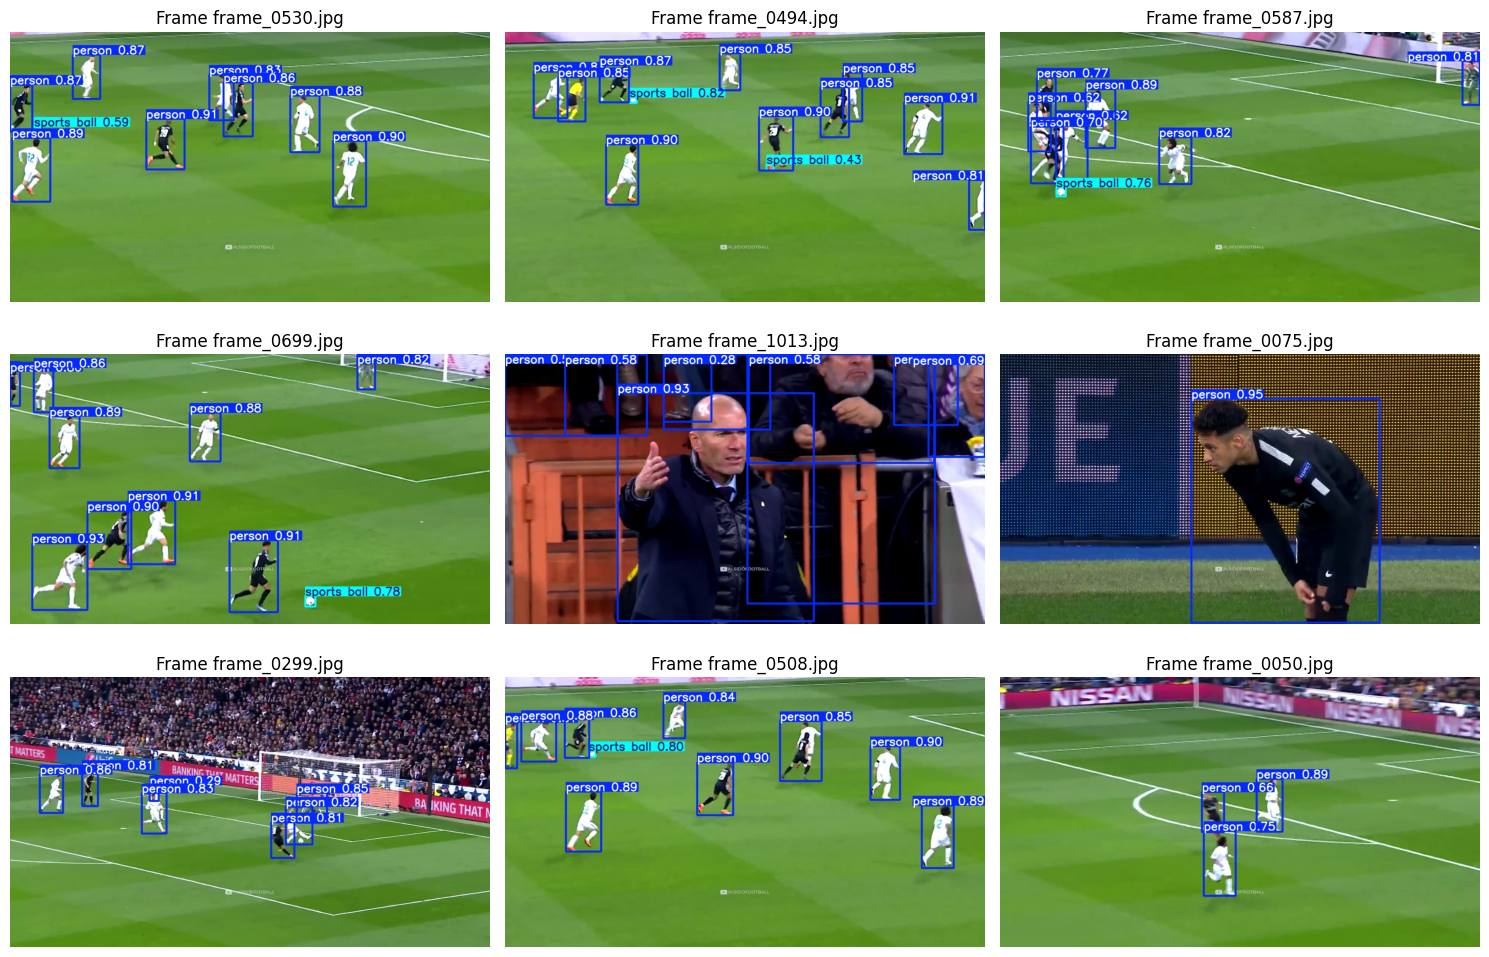

In [20]:
import matplotlib.pyplot as plt
import random
import os
import cv2

# Directory where images are saved
output_dir = "/kaggle/working/output_images/"

# List all image files in the directory
image_files = [f for f in os.listdir(output_dir) if f.endswith(".jpg")]

# Randomly select a few images to display
num_images_to_display = 9  # Number of images you want to display
selected_images = random.sample(image_files, min(num_images_to_display, len(image_files)))

# Calculate the number of rows and columns for the grid
num_columns = 3  # Number of images per row
num_rows = (num_images_to_display + num_columns - 1) // num_columns  # Calculate rows needed

# Plot the selected images in a grid
plt.figure(figsize=(15, 10))
for i, image_file in enumerate(selected_images):
    image_path = os.path.join(output_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying

    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Frame {image_file}")

plt.tight_layout()  # Adjust the spacing between images
plt.show()


## Key Points About the Output

### Bounding Boxes and Labels
- Each bounding box encloses a detected object. The label at the top of the box indicates the class of the object, such as "person" or "sports ball."
- The number beside the label is the **confidence score**, which ranges from 0 to 1. This score indicates how confident the model is that the detected object belongs to the specified class. Higher confidence scores mean more reliable detections.

### Multiple Detections
- Since this is a football match, there are several detections of the "person" class in each frame, corresponding to the players and other people in the scene.
- The model is quite effective at detecting people, even when they are moving or partially occluded (blocked) by other objects.

### Tracking Movement
- The frames demonstrate how the model detects objects continuously as the game progresses. Although we are not using a tracking algorithm like DeepSORT here, the sequence of detections gives a sense of how tracking could work.
- The bounding boxes move and change in position as the players and ball move across the field, which is crucial for analyzing player movements or game strategies.

### Practical Applications
- **Sports Analysis**: This type of object detection can be used to track players and the ball, analyze game tactics, or generate player statistics.
- **Real-Time Monitoring**: In real-time scenarios, this setup could help coaches or analysts get insights during live matches.

### Challenges and Observations
- **Occlusions**: In some frames, players might overlap or be partially hidden behind others. The model still manages to detect most of them, but occlusions can be challenging for any detection system.
- **Confidence Variability**: The confidence scores vary depending on factors like the player’s visibility, lighting conditions, or the angle of view.

---

## Overall Analysis
The output demonstrates the power of YOLOv5 in identifying and labeling objects accurately in a dynamic sports environment. Even with the fast-paced movement of players and the ball, the model effectively highlights relevant objects, providing a foundation for deeper analysis or real-time decision-making.

This kind of detection is especially useful in sports analytics, where understanding player positioning and ball movement is crucial. You could further enhance this setup by incorporating tracking algorithms to follow objects across frames and gain insights like speed, direction, or player interactions.

Let me know if you have any specific questions or need further clarification on any part of the output!
